## Introduction

In this example, we'll implement DreamBooth, a fine-tuning technique to teach new visual concepts to text-conditioned Diffusion models with just 3 - 5 images. DreamBooth was proposed in [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://arxiv.org/abs/2208.12242) by Ruiz et al. 

DreamBooth, in a sense, is similar to the [traditional way of fine-tuning a text-conditioned Diffusion model except](https://keras.io/examples/generative/finetune_stable_diffusion/) for a few gotchas. This example assumes that you have basic familiarity with Diffusion models and how to fine-tune them. Here are some reference examples that might help you to get familiarized quickly:

* [High-performance image generation using Stable Diffusion in KerasCV](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/)
* [Teach StableDiffusion new concepts via Textual Inversion](https://keras.io/examples/generative/fine_tune_via_textual_inversion/)
* [Fine-tuning Stable Diffusion](https://keras.io/examples/generative/finetune_stable_diffusion/)

Running below line in the notebook makes sure that we have installed the version of TensorFlow that supports GPU, and that TensorFlow can detect the GPUs. If everything goes right, it should return `True` and a list that consists of a GPU. The version should be equal to or greater than 2.11 to support the correct version of keras_cv.

In [2]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())
print(tf.config.list_logical_devices('GPU'))
print(tf.__version__)

True
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.11.0


If you're running the code, please ensure you're using a GPU with at least 24 GBs of VRAM. 

## Initial imports

In [3]:
import tensorflow as tf 

from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


/home/ubuntu/miniconda3/envs/my_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Usage of DreamBooth

... is very versatile. By teaching Stable Diffusion about your favorite visual concepts, you can 

* Recontextualize objects in interesting ways:

  ![](https://i.imgur.com/4Da9ozw.png)

* Generate artistic renderings of the underlying visual concept: 

  ![](https://i.imgur.com/nI2N8bI.png)


And many other applications. We welcome you to check out the original DreamBooth paper in [this regard](https://arxiv.org/abs/2208.12242). 

## Download the instance and class images

DreamBooth uses a technique called "prior preservation" to meaningfully guide the training procedure such that the fine-tuned models can still preserve some of the prior semantics of the visual concept you're introducing. To know more about the idea of "prior preservation" refer to [this document](https://dreambooth.github.io/).

Here, we need to introduce a few key terms specific to DreamBooth:

* **Unique class**: Examples include "dog", "person", etc. In this example, we use "dog". 
* **Unique identifier**: A unique identifier that is prepended to the unique class while forming the "instance prompts". In this example, we use "sks" as this unique identifier. 
* **Instance prompt**: Denotes a prompt that best describes the "instance images". An example prompt could be - "f"a photo of {unique_id} {unique_class}". So, for our example, this becomes - "a photo  of sks dog".
* **Class prompt**: Denotes a prompt without the unique identifier. This prompt is used for generating "class images" for prior preservation. For our example, this prompt is - "a photo of dog".
* **Instance images**: Denote the images that represent the visual concept you're trying to teach aka the "instance prompt". This number is typically just 3 - 5. We typically gather these images ourselves. 
* **Class images**: Denote the images generated using the "class prompt" for using prior preservation in DreamBooth training. We leverage the pre-trained model before fine-tuning it to generate these class images. Typically, 200 - 300 class images are enough.

In code, this generation process looks quite simply:

```py
from tqdm import tqdm
import numpy as np 
import hashlib
import keras_cv
import PIL 
import os

class_images_dir = "class-images"
os.makedirs(class_images_dir, exist_ok=True)

model = keras_cv.models.StableDiffusion(img_width=512, img_height=512, jit_compile=True)

class_prompt = "illustration style"
num_imgs_to_generate = 200 
for i in tqdm(range(num_imgs_to_generate)):
    images = model.text_to_image(
        class_prompt,
        batch_size=3,
    )
    idx = np.random.choice(len(images))
    selected_image = PIL.Image.fromarray(images[idx])
    
    hash_image = hashlib.sha1(selected_image.tobytes()).hexdigest()
    image_filename = os.path.join(class_images_dir, f"{hash_image}.jpg")
    selected_image.save(image_filename)
```

To keep the runtime of this example short, the authors of this example have gone ahead and generated some class images using [this notebook](https://colab.research.google.com/gist/sayakpaul/6b5de345d29cf5860f84b6d04d958692/generate_class_priors.ipynb). 

**Note** that prior preservation is an optional technique used in DreamBooth, but it almost always helps in improving the quality of the generated images. 

In [4]:
# instance_images_root = tf.keras.utils.get_file(
#     origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/instance-images.tar.gz",
#     untar=True
# )
# class_images_root = tf.keras.utils.get_file(
#     origin="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/class-images.tar.gz",
#     untar=True
# )

In [5]:
instance_images_root = "dataset/instance-images"
class_images_root = "dataset/class-images"

## Visualize images

First, let's load the image paths. 

In [6]:
from imutils import paths

instance_image_paths = list(paths.list_images(instance_images_root))
class_image_paths = list(paths.list_images(class_images_root))

instance_image_paths, class_image_paths[:5]

(['dataset/instance-images/professor-garlick.jpg',
  'dataset/instance-images/ge8.jpg',
  'dataset/instance-images/ge-6.jpg',
  'dataset/instance-images/ge-5.jpg',
  'dataset/instance-images/ge-7.jpg',
  'dataset/instance-images/ge-1.jpg',
  'dataset/instance-images/ge-4.jpg',
  'dataset/instance-images/ge-3.jpg'],
 ['dataset/class-images/grf-s3.jpg',
  'dataset/class-images/grf-s1.jpg',
  'dataset/class-images/grf-s2.jpg',
  'dataset/class-images/sly-s2.jpg',
  'dataset/class-images/hfp.jpg'])

Then we load the images from the paths. 

In [7]:
from PIL import Image
import numpy as np

def load_images(image_paths):
    images = [] 
    for path in image_paths:
        image = Image.open(path)
        images.append(np.array(image))
    return images

And then we make use a utility function to plot the loaded images. 

In [8]:
import matplotlib.pyplot as plt

def plot_images(images, title=None):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        if title is not None:
            plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

**Instance images**:

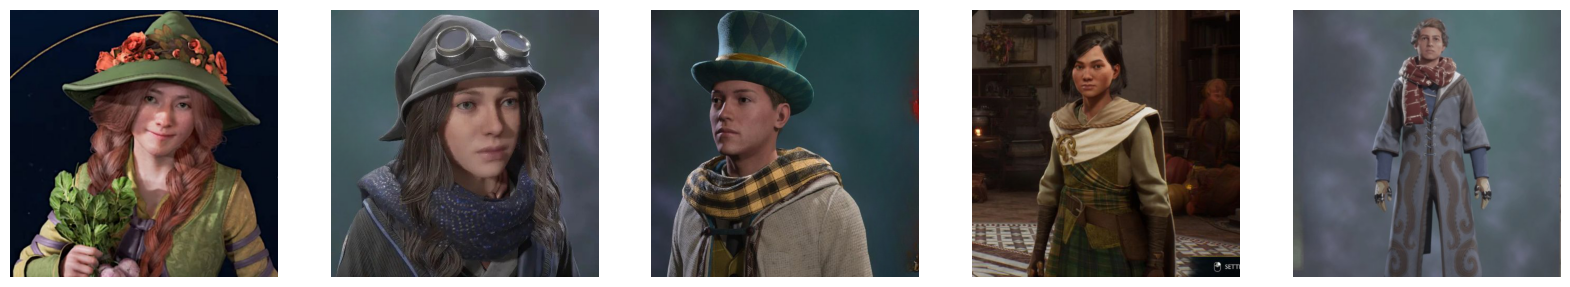

In [9]:
plot_images(load_images(instance_image_paths[:5]))

**Class images**:

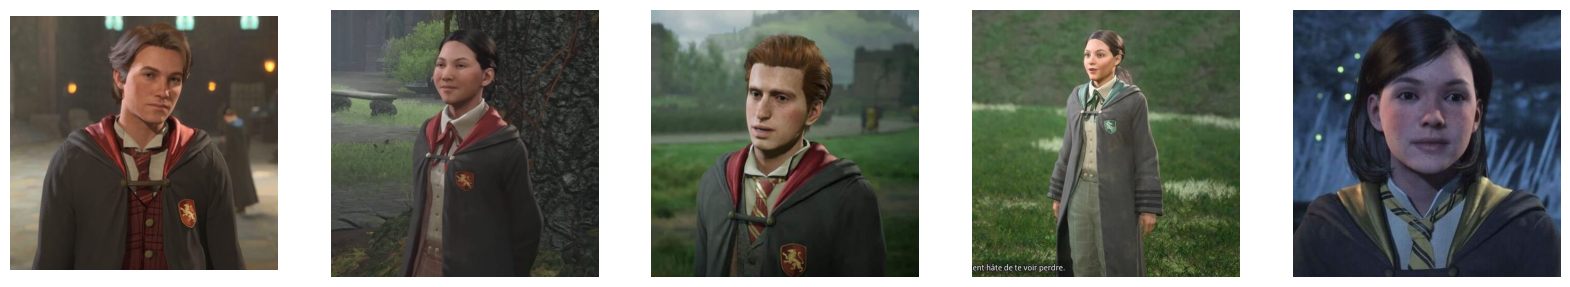

In [10]:
plot_images(load_images(class_image_paths[:5]))

## Prepare datasets

Dataset preparation includes two stages: (1): preparing the captions, (2) processing the images.

### Prepare the captions

In [11]:
# Since we're using prior preservation, we need to match the number
# of instance images we're using. We just repeat the instance image paths
# to do so. 
new_instance_image_paths = []
for index in range(len(class_image_paths)):
    instance_image = instance_image_paths[index % len(instance_image_paths)]
    new_instance_image_paths.append(instance_image)

In [12]:
# We just repeat the prompts / captions per images. 
unique_id = "[legacy]" #"sks"
class_label = "hogwarts" #"dog"

instance_prompt = f"{class_label} {unique_id} student"
instance_prompts = [instance_prompt] * len(new_instance_image_paths)

class_prompt = f"{class_label} student"
class_prompts = [class_prompt] * len(class_image_paths)

Next, we embed the prompts to save some compute.  

In [13]:
import numpy as np
import itertools

# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
padding_token = 49407
max_prompt_length = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

# Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [padding_token] * (max_prompt_length - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(instance_prompts) + len(class_prompts), max_prompt_length))

for i, caption in enumerate(itertools.chain(instance_prompts, class_prompts)):
    tokenized_texts[i] = process_text(caption)


# We also pre-compute the text embeddings to save some memory during training. 
POS_IDS = tf.convert_to_tensor([list(range(max_prompt_length))], dtype=tf.int32)
text_encoder = TextEncoder(max_prompt_length)

gpus = tf.config.list_logical_devices("GPU")

# Ensure the computation takes place on a GPU.
with tf.device(gpus[0].name):
    embedded_text = text_encoder(
        [tf.convert_to_tensor(tokenized_texts), POS_IDS], training=False
    ).numpy()

# To ensure text_encoder doesn't occupy any GPU space.
del text_encoder

492466864/492466864 [==============================] - 2s 0us/step


2023-03-27 14:25:55.571045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Prepare the images

In [14]:
import keras_cv

resolution = 512
auto = tf.data.AUTOTUNE

augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.CenterCrop(resolution, resolution),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (resolution, resolution))
    return image, tokenized_text


def apply_augmentation(image_batch, embedded_tokens):
    return augmenter(image_batch), embedded_tokens


def prepare_dict(instance_only=True):
    def fn(image_batch, embedded_tokens):
        if instance_only:
            batch_dict = {
                "instance_images": image_batch,
                "instance_embedded_texts": embedded_tokens,
            }
            return batch_dict
        else:
            batch_dict = {
                "class_images": image_batch,
                "class_embedded_texts": embedded_tokens,
            }
            return batch_dict
    return fn


def assemble_dataset(
    image_paths, embedded_texts, instance_only=True, batch_size=1
):  
    dataset = tf.data.Dataset.from_tensor_slices(
        (image_paths, embedded_texts)
    )
    dataset = dataset.map(process_image, num_parallel_calls=auto)
    dataset = dataset.shuffle(5, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=auto)

    prepare_dict_fn = prepare_dict(instance_only=instance_only)
    dataset = dataset.map(prepare_dict_fn, num_parallel_calls=auto)
    return dataset

## Assemble dataset

In [15]:
instance_dataset = assemble_dataset(
    new_instance_image_paths, 
    embedded_text[:len(new_instance_image_paths)],
)
class_dataset = assemble_dataset(
    class_image_paths, 
    embedded_text[len(new_instance_image_paths):],
    instance_only=False
)
train_dataset = tf.data.Dataset.zip((instance_dataset, class_dataset))

## Check shapes

Now that the dataset has been prepared, let's quickly check what's inside it. 

In [16]:
sample_batch = next(iter(train_dataset))
print(sample_batch[0].keys(), sample_batch[1].keys())

dict_keys(['instance_images', 'instance_embedded_texts']) dict_keys(['class_images', 'class_embedded_texts'])


In [17]:
for k in sample_batch[0]:
    print(k, sample_batch[0][k].shape)

instance_images (1, 512, 512, 3)
instance_embedded_texts (1, 77, 768)


In [18]:
for k in sample_batch[1]:
    print(k, sample_batch[1][k].shape)

class_images (1, 512, 512, 3)
class_embedded_texts (1, 77, 768)


During training, we make use of these keys to gather the images and text embeddings and concat them accordingly. 

## DreamBooth training loop

Our DreamBooth training loop is very much inspired by [this script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py) provided by the Diffusers team at Hugging Face. However, there is an important difference to note. We only fine-tune the UNet (the model responsible for predicting noise) and don't fine-tune the text encoder in this example. If you're looking for an implementation that also performs the additional fine-tuning of the text encoder, refer to [this repository](https://github.com/sayakpaul/dreambooth-keras/). 

In [19]:
import tensorflow.experimental.numpy as tnp

class DreamBoothTrainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        prior_loss_weight=1.0,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.prior_loss_weight = prior_loss_weight
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        instance_batch = inputs[0]
        class_batch = inputs[1]

        instance_images = instance_batch["instance_images"]
        instance_embedded_text = instance_batch["instance_embedded_texts"]
        class_images = class_batch["class_images"]
        class_embedded_text = class_batch["class_embedded_texts"]

        images = tf.concat([instance_images, class_images], 0)
        embedded_texts = tf.concat([instance_embedded_text, class_embedded_text], 0)
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, embedded_texts], training=True
            )
            loss = self.compute_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def compute_loss(self, target, model_pred):
        # Chunk the noise and model_pred into two parts and compute the loss
        # on each part separately.
        # Since the first half of the inputs has instance samples and the second half
        # has class samples, we do the chunking accordingly. 
        model_pred, model_pred_prior = tf.split(model_pred, num_or_size_splits=2, axis=0)
        target, target_prior = tf.split(target, num_or_size_splits=2, axis=0)

        # Compute instance loss.
        loss = self.compiled_loss(target, model_pred)

        # Compute prior loss.
        prior_loss = self.compiled_loss(target_prior, model_pred_prior)

        # Add the prior loss to the instance loss.
        loss = loss + self.prior_loss_weight * prior_loss
        return loss

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )

## Trainer initialization

In [20]:
# Comment it if you are not using a GPU having tensor cores.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB, compute capability 8.0


2023-03-27 14:25:57.973667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [21]:
use_mp = True # Set it to False if you're not using a GPU with tensor cores. 

image_encoder = ImageEncoder(resolution, resolution)
dreambooth_trainer = DreamBoothTrainer(
    diffusion_model=DiffusionModel(resolution, resolution, max_prompt_length),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=use_mp,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://github.com/huggingface/diffusers/tree/main/examples/dreambooth
lr = 5e-6
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
dreambooth_trainer.compile(optimizer=optimizer, loss="mse")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
3439090152/3439090152 [==============================] - 164s 0us/step


## Train!

We first calculate the number of epochs, we need to train for.

In [22]:
import math

num_update_steps_per_epoch = train_dataset.cardinality()
max_train_steps = 800
epochs =  math.ceil(max_train_steps / num_update_steps_per_epoch)
print(f"Training for {epochs} epochs.")

Training for 134 epochs.


And then we start training!

In [23]:
import time

start_time = time.process_time()
ckpt_path = "dreambooth-unet.h5" 
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
dreambooth_trainer.fit(train_dataset, epochs=epochs, callbacks=[ckpt_callback])
end_time = time.process_time()
print("Training time elapsed = {} seconds".format((start_time - end_time)))

Epoch 1/134
Instructions for updating:
Use fn_output_signature instead


2023-03-27 14:31:20.493080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-27 14:31:27.386595: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f5b10341d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-27 14:31:27.386626: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-03-27 14:31:27.390688: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-27 14:31:27.515205: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 [==============================] - 194s 1s/step - loss: 0.1219
Epoch 2/134
6/6 [==============================] - 7s 1s/step - loss: 0.0695
Epoch 3/134
6/6 [==============================] - 8s 1s/step - loss: 0.0763
Epoch 4/134
6/6 [==============================] - 8s 1s/step - loss: 0.1343
Epoch 5/134
6/6 [==============================] - 7s 1s/step - loss: 0.1203
Epoch 6/134
6/6 [==============================] - 8s 1s/step - loss: 0.0961
Epoch 7/134
6/6 [==============================] - 7s 1s/step - loss: 0.0805
Epoch 8/134
6/6 [==============================] - 8s 2s/step - loss: 0.0459
Epoch 9/134
6/6 [==============================] - 7s 1s/step - loss: 0.1797
Epoch 10/134
6/6 [==============================] - 7s 1s/step - loss: 0.1131
Epoch 11/134
6/6 [==============================] - 7s 1s/step - loss: 0.1290
Epoch 12/134
6/6 [==============================] - 7s 1s/step - loss: 0.1239
Epoch 13/134
6/6 [==============================] - 8s 1s/step - loss: 0.1431
Epoch

6/6 [==============================] - 7s 1s/step - loss: 0.1357
Epoch 120/134
6/6 [==============================] - 7s 1s/step - loss: 0.1120
Epoch 121/134
6/6 [==============================] - 7s 1s/step - loss: 0.1146
Epoch 122/134
6/6 [==============================] - 7s 1s/step - loss: 0.1517
Epoch 123/134
6/6 [==============================] - 6s 1s/step - loss: 0.0747
Epoch 124/134
6/6 [==============================] - 7s 1s/step - loss: 0.1183
Epoch 125/134
6/6 [==============================] - 7s 1s/step - loss: 0.0702
Epoch 126/134
6/6 [==============================] - 6s 1s/step - loss: 0.1306
Epoch 127/134
6/6 [==============================] - 7s 1s/step - loss: 0.0507
Epoch 128/134
6/6 [==============================] - 7s 1s/step - loss: 0.0435
Epoch 129/134
6/6 [==============================] - 7s 1s/step - loss: 0.0430
Epoch 130/134
6/6 [==============================] - 7s 1s/step - loss: 0.1372
Epoch 131/134
6/6 [==============================] - 7s 1s/step - 

# Model Hosting
To host the model, we will use [Hugging Face Hub](https://huggingface.co/). It follows an authentication with token so we need to get our write token from [this page](https://huggingface.co/settings/tokens) and we will use `notebook_login()` to pass the token. Hosting the model using utils from Hugging Face Hub enables better versioning of models with reproducibility tools, e.g. model cards, and also easy loading without storing the model locally.

In [24]:
# Initialize a new Stable Diffusion model.
dreambooth_model = keras_cv.models.StableDiffusion(
    img_width=resolution, img_height=resolution, jit_compile=True
)
dreambooth_model.diffusion_model.load_weights(ckpt_path)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [27]:
!pip install huggingface-hub ipywidgets

/bin/bash: /home/ubuntu/miniconda3/envs/my_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.1/198.1 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 138.8 MB/s eta 0:00:00


In [31]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /home/ubuntu/.cache/huggingface/token
Login successful


To host our model, we will use `push_to_hub_keras()`. This function will save the model as `SavedModel`, create a model card that we will later edit, and push our model to Hugging Face. We will pass only the diffusion model, and provide the function with a repository ID (in this case, `merve/dreambooth_diffusion_model`). 
During push to hub, you might get warnings. Feel free to ignore them.

In [32]:
from huggingface_hub import push_to_hub_keras

hf_username = "tgohblio"
config = dreambooth_model.diffusion_model.get_config()
repo_id = f"{hf_username}/dreambooth_diffusion_model"
push_to_hub_keras(dreambooth_model.diffusion_model, repo_id, config=config)

INFO:tensorflow:Assets written to: /tmp/tmpaiyz9ydr/tgohblio/dreambooth_diffusion_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpaiyz9ydr/tgohblio/dreambooth_diffusion_model/assets


Upload 2 LFS files:   0%|                                                                         | 0/2 [00:00<?, ?it/s]
fingerprint.pb:   0%|                                                                        | 0.00/55.0 [00:00<?, ?B/s]

saved_model.pb:   0%|                                                              | 8.19k/20.8M [00:00<37:43, 9.19kB/s]
fingerprint.pb: 100%|█████████████████████████████████████████████████████████████████| 55.0/55.0 [00:00<00:00, 62.0B/s]

saved_model.pb:   1%|▎                                                              | 123k/20.8M [00:01<03:27, 99.6kB/s]

saved_model.pb:   2%|█▏                                                              | 369k/20.8M [00:01<01:10, 290kB/s]

saved_model.pb:   3%|█▋                                                              | 565k/20.8M [00:02<00:51, 393kB/s]

saved_model.pb:   7%|████▍                         

'https://huggingface.co/tgohblio/dreambooth_diffusion_model/tree/main/'

## Inference

We can load the diffusion model model from the Hub using `from_pretrained_keras()` and set it as the value of the `_diffusion_model` attribute of the `StableDiffusion` model. We will then infer with the loaded model.

In [33]:
from huggingface_hub import from_pretrained_keras


sd_dreambooth_model = keras_cv.models.StableDiffusion(
    img_width=resolution, img_height=resolution, jit_compile=True, 
)
loaded_diffusion_model = from_pretrained_keras(repo_id)
sd_dreambooth_model._diffusion_model = loaded_diffusion_model

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Fetching 8 files:   0%|                                                                           | 0/8 [00:00<?, ?it/s]







Fetching 8 files:  12%|████████▍                                                          | 1/8 [00:02<00:16,  2.33s/it]











Fetching 8 files:  62%|█████████████████████████████████████████▉                         | 5/8 [00:03<00:01,  1.95it/s]




Fetching 8 files:  75%|██████████████████████████████████████████████████▎                | 6/8 [00:04<00:01,  1.50it/s]
































































































































































Fetching 8 files: 100%|███████████████████████████████████████████████████████████████████| 8/8 [02:46<00:00, 20.81s/it]


We can now perform inference with the model.

84/84 [==============================] - 27s 316ms/step


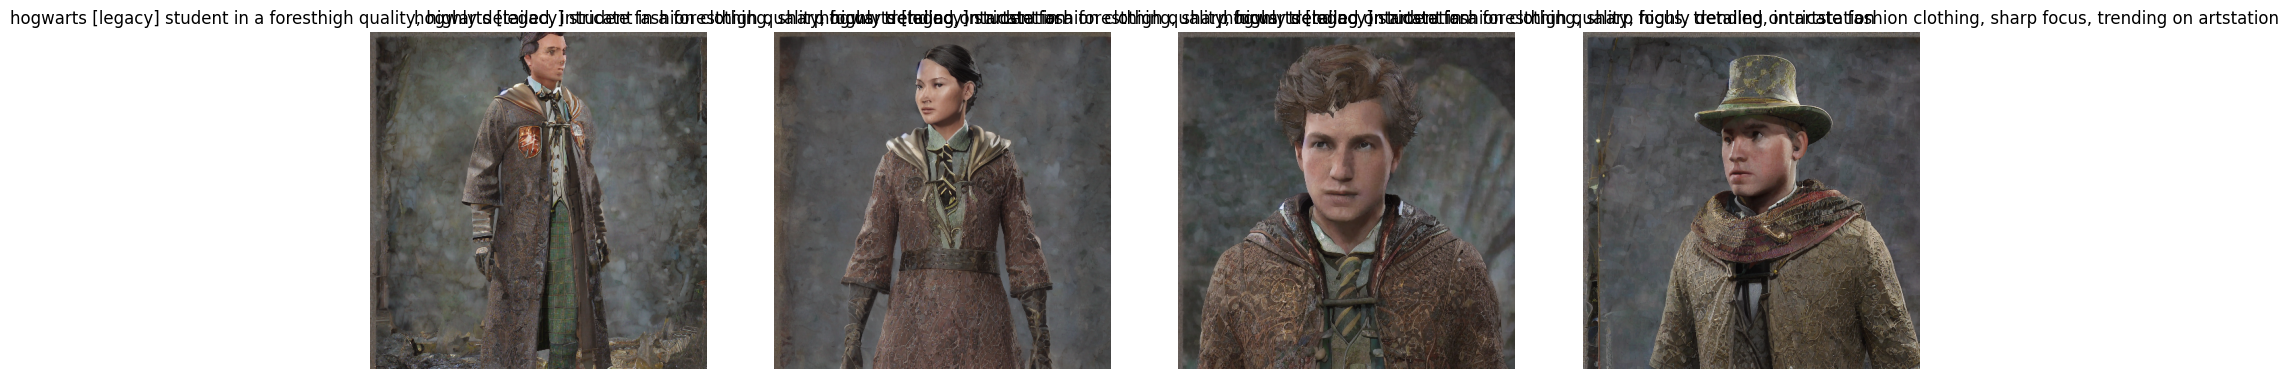

In [70]:
# Note how the unique idenitifier and the class have been used in the prompt.
additional_prompt = "high quality, highly detailed, intricate fashion clothing, sharp focus, trending on artstation"
prompt = f"{class_label} {unique_id} student in a forest" + additional_prompt
negative_prompt = "(blurry), (face out of frame), ugly, deformed, ((poorly drawn face)), bad proportions"
num_imgs_to_gen = 4
guidance_scale = 7.0
inference_steps = 80   # number of iterations (controls image quality)
seed = 7895031         # set this to always get the same image from the same prompt

generated_img = sd_dreambooth_model.text_to_image(
    prompt,
    negative_prompt=negative_prompt,
    batch_size=num_imgs_to_gen,
    num_steps=inference_steps,
    unconditional_guidance_scale=guidance_scale,
    seed=seed
)
plot_images(generated_img, prompt)

Feel free to experiment with different prompts (don't forget to add the unique identifer and the class label!) to see how the results change. We welcome you to check out our codebase and more experimental results [here](https://github.com/sayakpaul/dreambooth-keras#results). You can also refer to [this blog post](https://huggingface.co/blog/dreambooth) to get more experimentation ideas.

## Acknowledgements

* Thanks to the [DreamBooth example script](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth.py) provided by Hugging Face which helped us a lot in getting the initial implementation ready quickly. 
* Getting DreamBooth to work on human faces can be challenging. We have compiled some general recoomendations [here](https://github.com/sayakpaul/dreambooth-keras#notes-on-preparing-data-for-dreambooth-training-of-faces). Thanks to [Abhishek Thakur](https://no.linkedin.com/in/abhi1thakur) for helping with these. 